# CV-Job Match Dataset Analysis
## Semantic Matching Between CVs and Job Descriptions

This notebook analyzes the CV-Job Match dataset to understand:
- How CVs align with job descriptions
- Similarity scoring mechanisms
- Features that indicate good matches
- Building models to predict CV-Job compatibility

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from wordcloud import WordCloud
import re
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load the Dataset

In [2]:
# Load training and test data
data_path = Path('../data/cv_job_match')
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTraining data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training samples: 6241
Test samples: 1759

Training data shape: (6241, 3)
Test data shape: (1759, 3)


## 2. Explore Dataset Structure

In [3]:
# Display first few rows
print("Training Data Sample:")
display(train_df.head())

print("\nColumn Names:")
print(train_df.columns.tolist())

print("\nData Types:")
print(train_df.dtypes)

print("\nMissing Values:")
print(train_df.isnull().sum())

Training Data Sample:


,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit



Column Names:
['resume_text', 'job_description_text', 'label']

Data Types:
resume_text             object
job_description_text    object
label                   object
dtype: object

Missing Values:
resume_text             0
job_description_text    0
label                   0
dtype: int64


In [4]:
# Basic statistics
print("Dataset Statistics:")
display(train_df.describe())

Dataset Statistics:


,resume_text,job_description_text,label
count,6241,6241,6241
unique,642,280,3
top,SummaryFinancial Accountant specializing in fi...,Calling all innovators find your future at Fi...,No Fit
freq,71,111,3143


## 3. Target Variable Analysis

Target variable: label

Target distribution:
label
No Fit           3143
Potential Fit    1556
Good Fit         1542
Name: count, dtype: int64


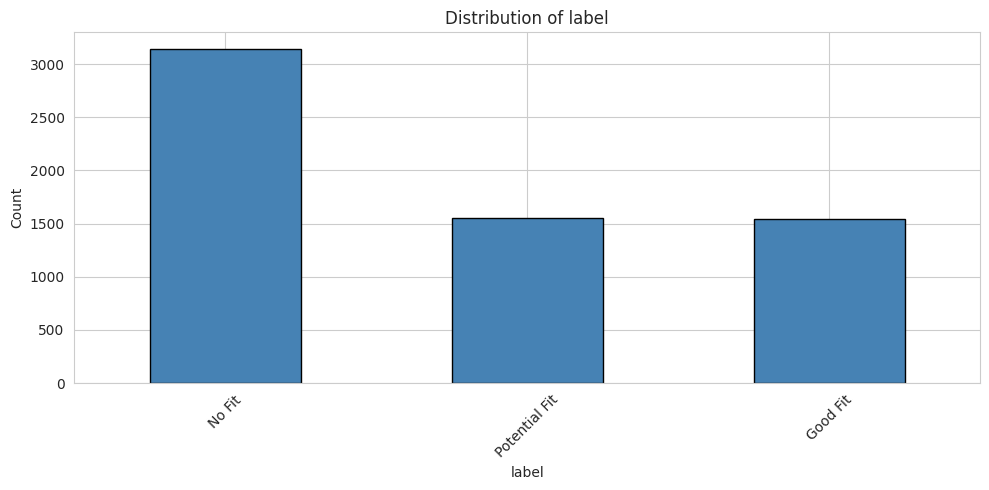

In [5]:
# Analyze target variable (match score or binary label)
# Adjust column name based on actual dataset structure
if 'label' in train_df.columns:
    target_col = 'label'
elif 'match_score' in train_df.columns:
    target_col = 'match_score'
elif 'target' in train_df.columns:
    target_col = 'target'
else:
    target_col = train_df.columns[-1]  # Assume last column is target

print(f"Target variable: {target_col}")
print(f"\nTarget distribution:")
print(train_df[target_col].value_counts())

# Visualize target distribution
plt.figure(figsize=(10, 5))
train_df[target_col].value_counts().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title(f'Distribution of {target_col}')
plt.xlabel(target_col)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Text Length Analysis

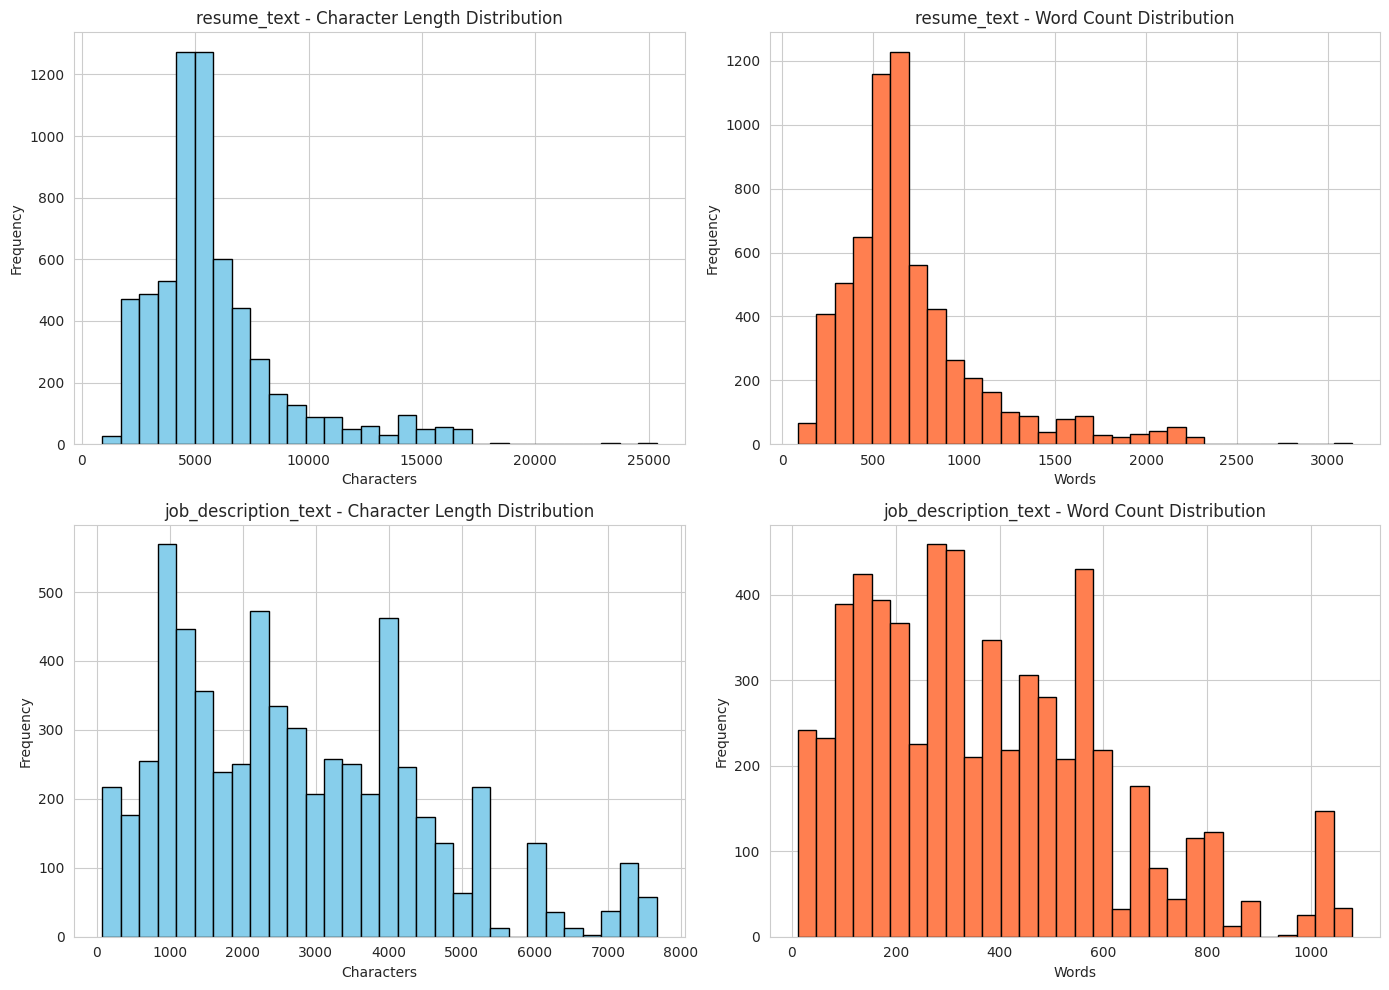

In [6]:
# Analyze text lengths
text_columns = [col for col in train_df.columns if train_df[col].dtype == 'object' and col != target_col]

for col in text_columns[:2]:  # Analyze first two text columns
    train_df[f'{col}_length'] = train_df[col].astype(str).apply(len)
    train_df[f'{col}_word_count'] = train_df[col].astype(str).apply(lambda x: len(x.split()))

# Plot length distributions
fig, axes = plt.subplots(len(text_columns[:2]), 2, figsize=(14, 5*len(text_columns[:2])))

if len(text_columns) >= 2:
    for idx, col in enumerate(text_columns[:2]):
        axes[idx, 0].hist(train_df[f'{col}_length'], bins=30, color='skyblue', edgecolor='black')
        axes[idx, 0].set_title(f'{col} - Character Length Distribution')
        axes[idx, 0].set_xlabel('Characters')
        axes[idx, 0].set_ylabel('Frequency')
        
        axes[idx, 1].hist(train_df[f'{col}_word_count'], bins=30, color='coral', edgecolor='black')
        axes[idx, 1].set_title(f'{col} - Word Count Distribution')
        axes[idx, 1].set_xlabel('Words')
        axes[idx, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Class Balance Analysis

Class Distribution (%):

label
No Fit           50.360519
Potential Fit    24.931902
Good Fit         24.707579
Name: proportion, dtype: float64


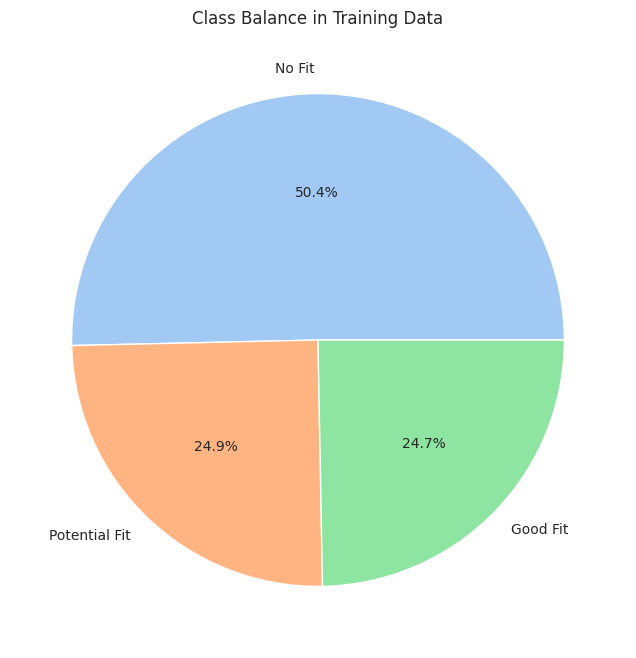

In [7]:
# Check class balance
class_distribution = train_df[target_col].value_counts(normalize=True) * 100
print("Class Distribution (%):\n")
print(class_distribution)

# Visualize class balance
plt.figure(figsize=(8, 8))
plt.pie(train_df[target_col].value_counts(), 
        labels=train_df[target_col].value_counts().index,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'))
plt.title('Class Balance in Training Data')
plt.show()

# Check if dataset is imbalanced
if class_distribution.max() > 70:
    print("\n⚠️ WARNING: Dataset appears to be imbalanced. Consider using:")
    print("   - Class weights in model training")
    print("   - Oversampling (SMOTE) or undersampling")
    print("   - Focal loss or other imbalanced-aware loss functions")

## 6. Text Content Analysis

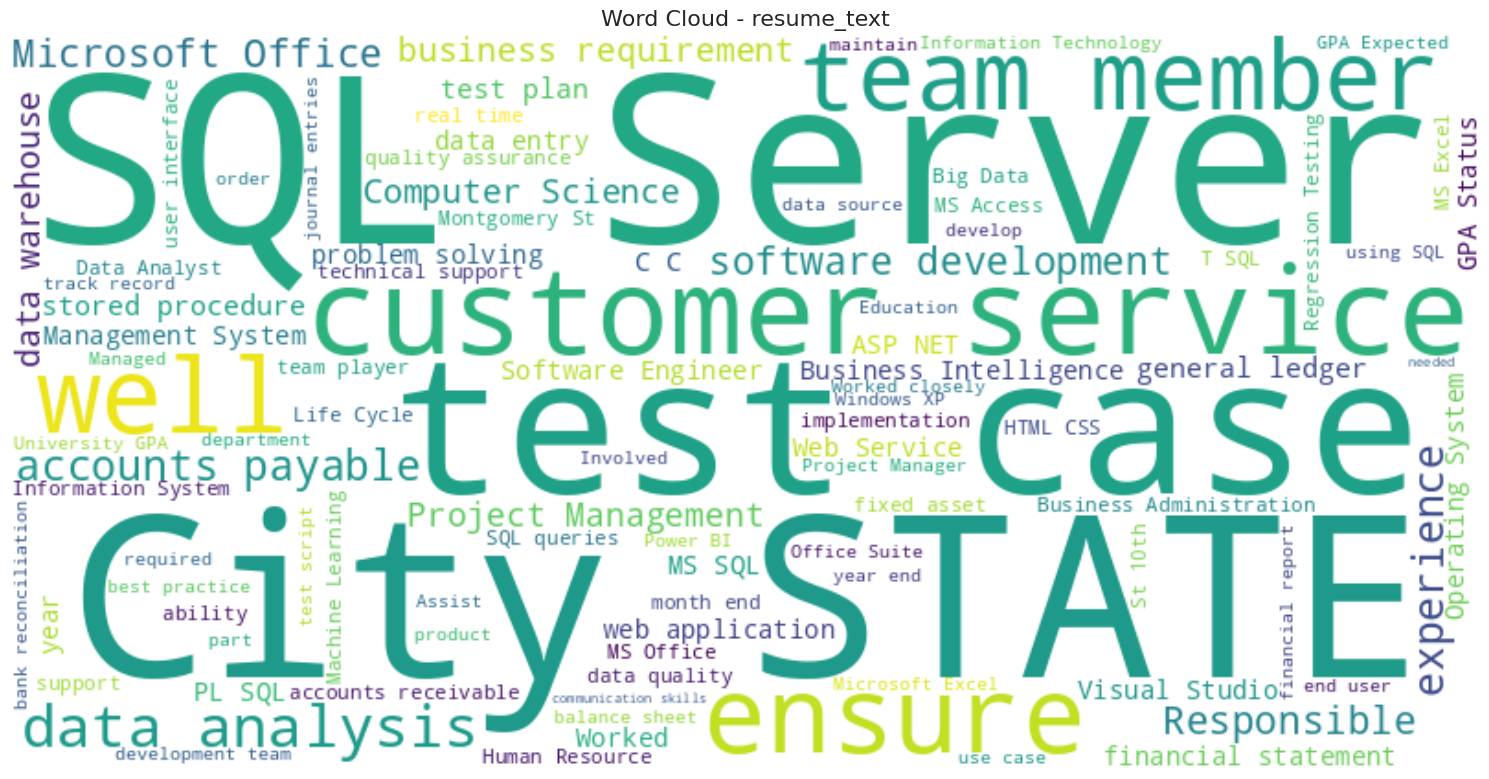

In [8]:
# Word cloud for the first text column
if len(text_columns) > 0:
    text_col = text_columns[0]
    all_text = ' '.join(train_df[text_col].astype(str).values)
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=100).generate(all_text)
    
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {text_col}', fontsize=16)
    plt.tight_layout()
    plt.show()

## 7. Correlation Analysis

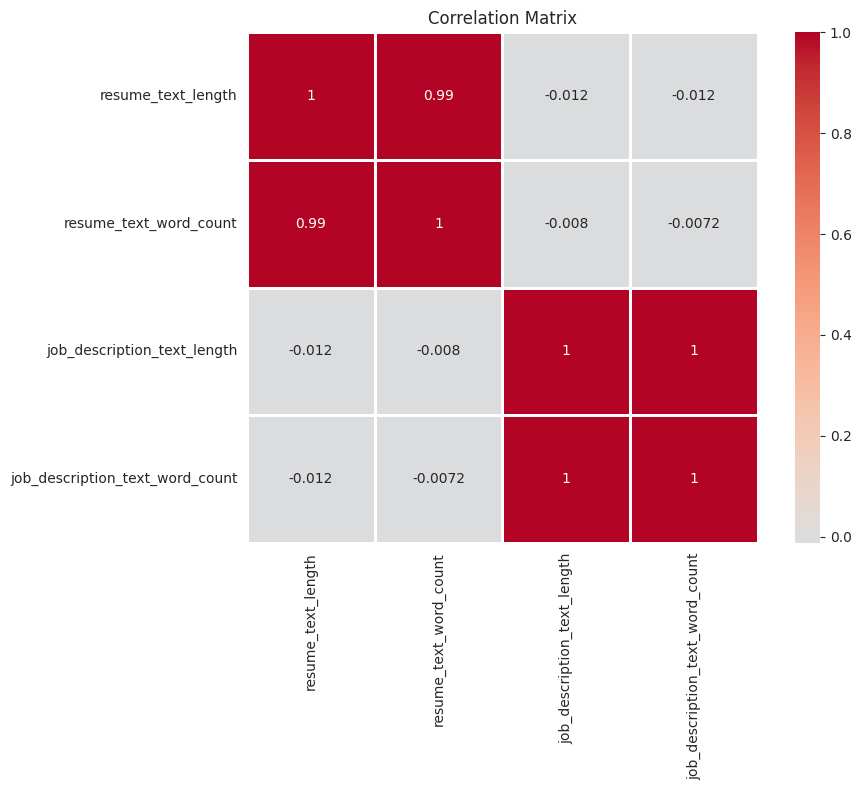

In [9]:
# Analyze correlations between text lengths and target
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = train_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=1)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()

## 8. Key Insights and Recommendations

### Findings:
- Document the structure of CV and job description texts
- Identify patterns in matched vs. unmatched pairs
- Note text length characteristics

### Recommendations for Preprocessing:
- Text cleaning and normalization
- Handling special characters and formatting
- Tokenization strategy
- Maximum sequence length determination

### Model Suggestions:
- **BERT/RoBERTa** for semantic similarity (using [CLS] token or sentence embeddings)
- **Sentence-BERT (SBERT)** specifically designed for semantic similarity
- **Cross-encoder models** for direct CV-Job pair scoring
- **Bi-encoder architecture** for efficient similarity computation
- Consider **Siamese Networks** with LSTM/Transformer encoders
- Evaluation metrics: Accuracy, Precision, Recall, F1-score, ROC-AUC

## 9. Sample Data Inspection

In [10]:
# Display sample positive and negative examples
print("Sample Matching Examples:")
print("=" * 80)

unique_labels = train_df[target_col].unique()
for label in unique_labels[:2]:
    sample = train_df[train_df[target_col] == label].iloc[0]
    print(f"\nLabel: {label}")
    print("-" * 80)
    for col in text_columns[:2]:
        print(f"{col}:")
        print(str(sample[col])[:300] + "...\n")

Sample Matching Examples:

Label: No Fit
--------------------------------------------------------------------------------
resume_text:
SummaryHighly motivated Sales Associate with extensive customer service and sales experience. Outgoing sales professional with track record of driving increased sales, improving buying experience and elevating company profile with target market.
Highlights-Soft Skills: Public Speaking, Public Relati...

job_description_text:
Net2Source Inc. is an award-winning total workforce solutions company recognized by Staffing Industry Analysts for our accelerated growth of 300% in the last 3 years with over 5500+ employees globally, with over 30+ locations in the US and global operations in 32 countries. We believe in providing s...


Label: Potential Fit
--------------------------------------------------------------------------------
resume_text:
Professional Summary5  years of experience on Database development and administration, knowledge of relational databa